# Bilag 4: Delanalyse 1

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import bilag_5_d1_riskkit as d1
from matplotlib.ticker import FuncFormatter

from datetime import datetime
%matplotlib inline

# Importering og filtrering af data

 ### Data for aktier og obligationer

In [2]:
d1_data = pd.read_excel("Data/bondsandstocks_data.xlsx",
                      header=0, index_col=0, parse_dates=True)
d1_data = d1_data['1973-01-31':'2020-12-31']

In [3]:
# Her sættes værdi lig sidste business dag i måneden
mnd_data = d1_data.resample('BMS').last()

In [4]:
mnd_afkast = mnd_data.pct_change().dropna()

In [5]:
# Her ændres datoformat til år og måned
mnd_afkast.index = mnd_afkast.index.to_period('M')

In [6]:
mnd_afkast.columns = ['Obligationer', 'Aktier']

## Renter

In [7]:
rente_data = pd.read_excel("Data/Renter.xlsx",
                      header=0, index_col=0, parse_dates=True)

In [8]:
rente_data.head(1)

,USGG3M,Libor USD
Date,,
1973-01-02,5.22,5.705666


### Risikofri rente 

In [9]:
rf_år = pd.DataFrame({'Risikofri Rente': rente_data['USGG3M']})
rf_år = rf_år['1973-01-31':'2020-12-31']/100

In [10]:
rf_måned = (1+rf_år)**(1/12)-1

In [11]:
# Her sættes værdi lig sidste business dag i måneden
mnd_rf = rf_måned.resample('BMS').last()

In [12]:
# Her ændres datoformat til år og måned
mnd_rf.index = mnd_rf.index.to_period('M')

In [13]:
#mnd_rf.columns = ['Risikofri Rente']
mnd_rf = mnd_rf['1973-02':]

### Lånerente: LIBOR USD

In [14]:
r_lån_år = pd.DataFrame({'Lånerente': rente_data['Libor USD']})
r_lån_år = r_lån_år['1973-01-31':'2020-12-31']/100

In [15]:
r_lån_mnd = (1+r_lån_år)**(1/12)-1

In [16]:
# Her sættes værdi lig sidste business dag i måneden
mnd_lån = r_lån_mnd.resample('BMS').last()

In [17]:
# Her ændres datoformat til år og måned
mnd_lån.index = mnd_lån.index.to_period('M')

In [18]:
# Her navngives kolonner
#mnd_lån.columns = ['Lånerente']
mnd_lån = mnd_lån['1973-02':]

# Konstruering af porteføljer

mnd_afkast['Obligationer']## Statiske porteføljer

### Aktie portefølje bestående af S&P500

In [23]:
pf_aktie = pd.DataFrame({'Aktie': mnd_afkast['Aktier']})

In [24]:
pf_obligationer = pd.DataFrame({'Obligationer': mnd_afkast['Obligationer']})

In [25]:
pf_obligationer

,Obligationer
Date,
1973-02,-0.002627
1973-03,0.000000
1973-04,0.009420
1973-05,0.002208
1973-06,0.002703
...,...
2020-08,-0.010953
2020-09,0.001385
2020-10,-0.009427


### Traditionel 60/40 portefølje

In [26]:
# Her antages det at der rebalanceres månedligt
pf_6040 = 0.6*mnd_afkast['Aktier'] + 0.4*mnd_afkast['Obligationer']

In [27]:
pf_6040 = pd.DataFrame({'60/40 portefølje': pf_6040})

## Risk Parity porteføljer

### Funktion til optimering af RP vægte

In [28]:
# --------------------- Opdateret ud fra Bai et al, formel (13) - med kovarianser som input
from scipy.optimize import minimize

# Funktion der finder de optimale Risk Parity vægte
def optimale_rp_vægte(cov):
    """
    Denne funktion finder de optimale Risk Parity vægte,
    givet en tidsserie med månedlige kovarianser.
    """  
    n_aktiver = cov.shape[1]
    date_index = cov.index.get_level_values(0)
    datoindex = []
    for date, cov_date in cov.groupby(date_index):
        datoindex.append(date)
    optimale_rul_rp_vægte = pd.DataFrame(columns = ['Vægt obl.', 'Vægt akt.'], index=datoindex)
   
    # Her laves en DataFrame med værdier svarende til index nummer, så vi kan lokalisere
    # værdien der skal bruges med .iloc. Dette bruges i for-loopet til at finde værdien dagen før,
    # der skal indgå som gæt
    step = pd.DataFrame(columns = ['step'], index=datoindex)  
    step['step'] = np.arange(len(datoindex))
    
   
    for date, cov_date in cov.groupby(date_index):
        cov_mat = cov_date.reset_index('Date', drop=True).to_numpy()        
        if step['step'].loc[date] == 0:
            gæt = 1/ n_aktiver * np.ones(n_aktiver)
           
            #print(np.sqrt(12)*np.sqrt(cov_mat[0,0]))
            #print(np.sqrt(12)*np.sqrt(cov_mat[1,1]))
            #print(cov_mat[0,1]/(np.sqrt(cov_mat[0,0]*cov_mat[1,1])))
           
        else:
            gæt = optimale_rul_rp_vægte.iloc[step.loc[date]-1]
       
        rp_vægte = target_risk_contributions(cov_mat, gæt)
               
        optimale_rul_rp_vægte.loc[date] = rp_vægte
       
    return optimale_rul_rp_vægte

# The object function (13) in (Xi Bai et al.)
def orthants_object_function(x, beta, risk_budget, cov_matrix):
    res = 0.5 * np.dot(np.dot(x, cov_matrix), x) - sum(risk_budget * np.log(beta * x))    
    return res


def target_risk_contributions(cov_matrix, initial_guess):
    """
    Returnerer de porteføljevægte, der sikrer at risikobudgettet for
    det enkelte aktiv er så tæt på risikobudget som muligt,
    givet en kovariansmatrice.
    gæt anvendes i funktionen msd_risk
    """
    n = cov_matrix.shape[1] # antal aktiver
   
    beta = np.ones(n)
    bounds = tuple((0, None) if b > 0 else (None, 0) for b in beta)
    risk_budget = np.ones(len(beta))/n
    fconst = lambda w: np.sum(w) - 1
    cons = ({'type': 'eq', 'fun': fconst})

    res = minimize(lambda x: orthants_object_function(x, beta, risk_budget, cov_matrix),
                   initial_guess,
                   tol=10 ** -16,
                   bounds=bounds,
                   #constraints=cons,
                   options={'maxiter': 10000})  
 
    return res.x/np.sum(res.x)

### Kovariansmatrice

In [29]:
# Kovarians matrice med 5 års rullende vindue - til validering af risikobidrag
cov_rul = mnd_afkast.rolling(60).cov()
cov_rul.index.names = ['Date', 'Aktiv']
cov_test = cov_rul.iloc[120:] # Her fjernes de første 60 måneder, da de har NaN værdier

### Beregning af vægte i RP portefølje - ud fra optimizer

In [30]:
rp_ug_vægte = optimale_rp_vægte(cov_test)

<AxesSubplot:>

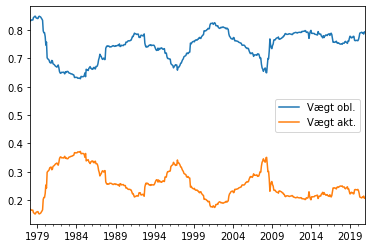

In [31]:
rp_ug_vægte.plot()

### Validering af vægte, ved beregning af risikobidrag

In [32]:
def risk_contribution(weights,cov):
    """
    Beregner risikobidrag i procent af den samlede portefølje volatilitet,
    givet vægte og en kovariansmatrice
    """
    total_portfolio_vol =  (weights.T @ cov @ weights)**0.5
    
    # Marginal contribution of each asset
    marginal_contrib = cov@weights
    
    # Risk contribution for each asset
    risk_contrib = np.multiply(marginal_contrib,weights.T)/total_portfolio_vol
    risk_contrib_pct = risk_contrib/total_portfolio_vol
    return risk_contrib_pct

def r_bidrag(w, cov):
    """
    Funktion der returnerer en DataFrame med det procentvise risikobidrag
    for hvert aktiv, givet tidsserier med vægte og kovariansmatricer
    """
    datoer = w.index
    n_steps = len(datoer)
    risiko_b = pd.DataFrame().reindex_like(w)
    risiko_b.columns = ['RB obl.', 'RB akt.']
    rb = 0
    for step in range(n_steps):
        # For cov ganges step med antal aktiver, for at få alle rækker i kovariansmatricen med
        rb = risk_contribution(w.iloc[step].ravel(), cov.iloc[step*2:step*2+2]) 
        risiko_b.iloc[step] = rb.ravel()      
    return risiko_b

In [33]:
risikobidrag = r_bidrag(rp_ug_vægte, cov_test)

## Naiv Risk Parity

In [34]:
std = mnd_afkast.rolling(60).std()[60:]
std_invers = (1/std)
invers = pd.DataFrame({'invers': std_invers.sum(axis=1)})
vægte_naiv_rp = std_invers.divide(invers['invers'], axis=0)

<AxesSubplot:title={'center':'Udvikling i standardafvigelse for aktier og obligationer 1983-2020'}, xlabel='Date'>

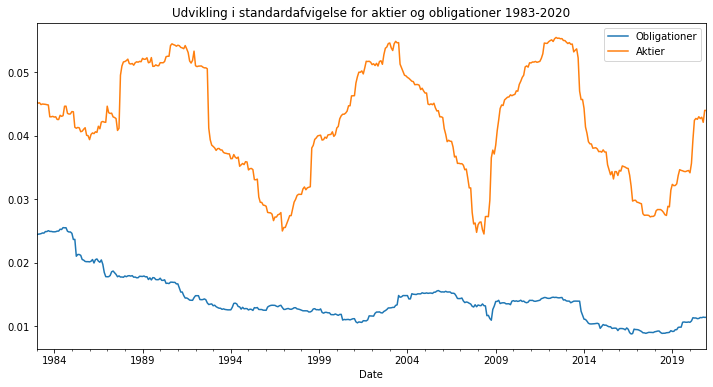

In [35]:
std['1983':].plot(figsize=(12,6), title='Udvikling i standardafvigelse for aktier og obligationer 1983-2020')

In [36]:
risikobidrag_naiv_rp = r_bidrag(vægte_naiv_rp, cov_test)

### Naiv RP - ugearet afkast

In [37]:
afkast_aktiver = mnd_afkast['1978-02':]
afkast_naiv_rp_ug = vægte_naiv_rp.iloc[:,0] * afkast_aktiver.iloc[:,0]+vægte_naiv_rp.iloc[:,1] * afkast_aktiver.iloc[:,1]
afkast_naiv_rp_ug = pd.DataFrame({'Risk Parity Ugearet afkast': afkast_naiv_rp_ug})

# Gearing af naiv RP portefølje

$$ w_{a} * R_{p} + (1 - w_{a}) * r_{borrowing} $$

In [38]:
std_rp_rul = afkast_naiv_rp_ug.rolling(60).std().dropna()

In [39]:
ønsket_vol_mnd = 0.1/(12**0.5)

In [40]:
# Her findes gearingsfaktor, og vægt i lånerente
gearings_faktor = ønsket_vol_mnd/std_rp_rul
gearings_faktor.rename(columns={'Risk Parity Ugearet afkast': 'Gearingsfaktor'}, inplace=True)
gearings_faktor['Vægt lånerente']=1 - gearings_faktor

In [41]:
# Her samles det vægtede, gearede afkast
afkast_naiv_rp_g = gearings_faktor['Gearingsfaktor']*afkast_naiv_rp_ug['Risk Parity Ugearet afkast']['1983-01':]\
+ gearings_faktor['Vægt lånerente']*mnd_lån['Lånerente']['1983-01':]
afkast_naiv_rp_g = pd.DataFrame({'Risk Parity Gearet afkast': afkast_naiv_rp_g})

# Sammenligning af porteføljer

## Wealth index for samlet periode

In [42]:
#Ny pf med ny gearet RP
pf_afkast = pd.DataFrame({'Obligationer': pf_obligationer['Obligationer']['1983-02':], '60/40 portefølje': pf_6040['60/40 portefølje']['1983-02':], 'Naiv Risk Parity Ugearet': afkast_naiv_rp_ug['Risk Parity Ugearet afkast']['1983-02':],'Aktie portefølje': pf_aktie['Aktie']['1983-02':], '60/40 portefølje': pf_6040['60/40 portefølje']['1983-02':], 'Naiv Risk Parity Ugearet': afkast_naiv_rp_ug['Risk Parity Ugearet afkast']['1983-02':], '60/40 portefølje': pf_6040['60/40 portefølje']['1983-02':], 'Naiv Risk Parity Ugearet': afkast_naiv_rp_ug['Risk Parity Ugearet afkast']['1983-02':],'Naiv Risk Parity Gearet': afkast_naiv_rp_g['Risk Parity Gearet afkast']['1983-02':]})

In [43]:
wi = 100*(1+pf_afkast).cumprod()

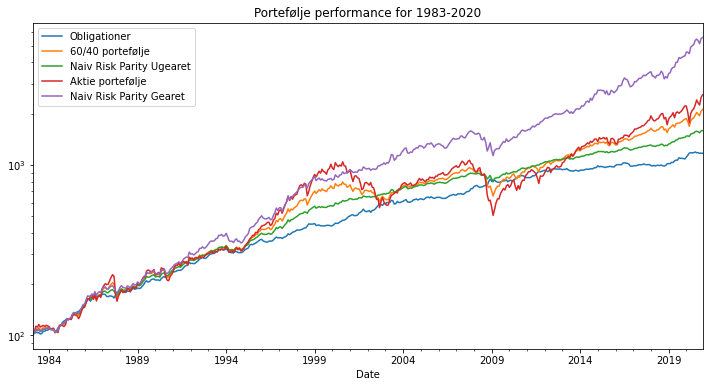

In [44]:
ax = wi.plot(figsize=(12,6), title='Portefølje performance for 1983-2020').set_yscale('log')

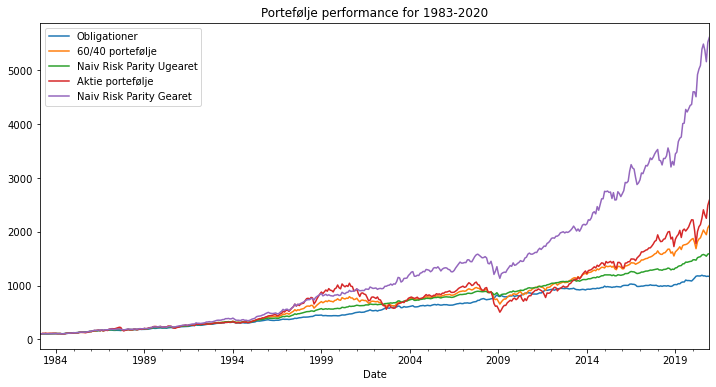

In [45]:
ax = wi.plot(figsize=(12,6), title='Portefølje performance for 1983-2020')

## Portefølje statistik for samlet periode

In [46]:
risikofri_rente = np.array(mnd_rf['1983-02':])

In [47]:
d1.stats(pf_afkast, risikofri_rente)

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
Obligationer,0.067068,0.047065,0.651215,-0.054186
60/40 portefølje,0.083859,0.091108,0.514676,-0.319125
Naiv Risk Parity Ugearet,0.075762,0.051042,0.765422,-0.102858
Aktie portefølje,0.089562,0.149760,0.349810,-0.525559
Naiv Risk Parity Gearet,0.112056,0.096606,0.767841,-0.283462


In [48]:
risikofri_rente_d2 = np.array(mnd_rf['2001-01':])

In [49]:
d1.stats(pf_afkast['2001-01':], risikofri_rente_d2)

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
Obligationer,0.043704,0.044132,0.675648,-0.049778
60/40 portefølje,0.053454,0.085534,0.460746,-0.319125
Naiv Risk Parity Ugearet,0.047700,0.038568,0.875171,-0.102858
Aktie portefølje,0.053667,0.150741,0.262625,-0.525559
Naiv Risk Parity Gearet,0.094706,0.101302,0.791263,-0.283462


In [50]:
d1.summary_stats(pf_afkast, risikofri_rente)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Obligationer,0.067068,0.047065,0.116624,3.571302,0.016198,0.016112,0.023067,0.651215,-0.054186
60/40 portefølje,0.083859,0.091108,-0.490486,4.656359,0.038800,0.037858,0.055953,0.514676,-0.319125
Naiv Risk Parity Ugearet,0.075762,0.051042,0.008108,4.113781,0.017633,0.017064,0.027467,0.765422,-0.102858
Aktie portefølje,0.089562,0.149760,-0.707462,5.319570,0.069167,0.068993,0.099342,0.349810,-0.525559
Naiv Risk Parity Gearet,0.112056,0.096606,-0.387927,4.151261,0.038889,0.039492,0.057564,0.767841,-0.283462


## Performance under kriser

In [51]:
# Fact and fiction perioder
p_1987_1987 = pf_afkast['1987-08':'1987-12']
p_2000_2002 = pf_afkast['2000-03':'2002-10']
p_2007_2009 = pf_afkast['2007-10':'2009-03']
p_2020_2020 = pf_afkast['2020-02':'2020-03']

In [52]:
# Beregning af akkumulerede afkast
ak_1987_1987 = (1+p_1987_1987).prod()-1
ak_2000_2002 = (1+p_2000_2002).prod()-1
ak_2007_2009 = (1+p_2007_2009).prod()-1
ak_2020_2020 = (1+p_2020_2020).prod()-1

In [53]:
tabel = pd.DataFrame({ '1987-08 til 1987-12': ak_1987_1987, '2000-03 til 2002-10': ak_2000_2002, '2007-10 til 2009-03': ak_2007_2009, '2020-02 til 2020-03': ak_2020_2020})
#tabel.index.names = ['Akkumuleret afkast']
tabel

,1987-08 til 1987-12,2000-03 til 2002-10,2007-10 til 2009-03,2020-02 til 2020-03
Obligationer,0.029712,0.310401,0.166804,0.056197
60/40 portefølje,-0.121371,-0.126505,-0.269612,-0.100834
Naiv Risk Parity Ugearet,-0.034672,0.162879,-0.054487,-0.004840
Aktie portefølje,-0.224628,-0.351766,-0.477406,-0.198706
Naiv Risk Parity Gearet,-0.057198,0.218042,-0.208560,-0.020122


In [54]:
# Performance for aktier og obligationer under kriserne
ao_1987_1987 = mnd_afkast['1987-08':'1987-12']
afk_ao_1987_1987 = (1+ao_1987_1987).prod()-1

ao_2000_2002 = mnd_afkast['2000-03':'2002-10']
afk_ao_2000_2002 = (1+ao_2000_2002).prod()-1

ao_2007_2009 = mnd_afkast['2007-10':'2009-03']
afk_ao_2007_2009 = (1+ao_2007_2009).prod()-1

ao_2020_2020 = mnd_afkast['2020-02':'2020-03']
afk_ao_2020_2020 = (1+ao_2020_2020).prod()-1

tabel_ao = pd.DataFrame({ '1987-08 til 1987-12': afk_ao_1987_1987, '2000-03 til 2002-10': afk_ao_2000_2002, '2007-10 til 2009-03': afk_ao_2007_2009, '2020-02 til 2020-03': afk_ao_2020_2020})
#tabel.index.names = ['Akkumuleret afkast']
tabel_ao

,1987-08 til 1987-12,2000-03 til 2002-10,2007-10 til 2009-03,2020-02 til 2020-03
Obligationer,0.029712,0.310401,0.166804,0.056197
Aktier,-0.224628,-0.351766,-0.477406,-0.198706


### Black Monday krisen i 1987

In [55]:
risikofri_rente_87 = np.array(mnd_rf['1987-08':'1987-12'])

In [56]:
d1.summary_stats(p_1987_1987, risikofri_rente_87)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Obligationer,0.072798,0.077917,0.484091,2.227625,0.024475,0.017288,0.020108,0.154803,-0.020108
60/40 portefølje,-0.266951,0.218559,-0.340314,1.947682,0.123247,0.101536,0.114560,-1.416711,-0.177313
Naiv Risk Parity Ugearet,-0.081203,0.080483,0.640900,1.816686,0.037548,0.026637,0.027961,-1.662278,-0.066575
Aktie portefølje,-0.456970,0.395506,-0.606674,2.094824,0.230606,0.191174,0.217630,-1.237415,-0.301698
Naiv Risk Parity Gearet,-0.131821,0.108354,0.626797,1.809442,0.052818,0.038318,0.040313,-1.677247,-0.094942


### Dot.com boblen

In [57]:
risikofri_rente_00 = np.array(mnd_rf['2000-03':'2002-10'])

In [58]:
d1.summary_stats(p_2000_2002, risikofri_rente_00)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Obligationer,0.106691,0.047839,-0.798886,3.096454,0.016679,0.017662,0.024407,1.420640,-0.042594
60/40 portefølje,-0.049455,0.107364,0.284310,2.325832,0.051833,0.046219,0.052884,-0.774245,-0.236272
Naiv Risk Parity Ugearet,0.058219,0.040004,0.831695,3.280914,0.011006,0.009518,0.011217,0.526382,-0.019205
Aktie portefølje,-0.150038,0.191096,0.228300,2.269120,0.098505,0.086479,0.101158,-0.944198,-0.462812
Naiv Risk Parity Gearet,0.076771,0.075668,0.729382,3.008860,0.024277,0.021960,0.024777,0.515466,-0.045164


### Finanskrisen

In [59]:
risikofri_rente_07 = np.array(mnd_rf['2007-10':'2009-03'])

In [60]:
d1.summary_stats(p_2007_2009, risikofri_rente_07)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Obligationer,0.108320,0.067531,0.285346,3.162897,0.020750,0.018982,0.029161,1.373817,-0.034267
60/40 portefølje,-0.188972,0.134457,-0.345150,2.944767,0.082275,0.073168,0.102096,-1.491589,-0.319125
Naiv Risk Parity Ugearet,-0.036663,0.076595,-0.251959,2.518348,0.039942,0.040588,0.044144,-0.656663,-0.102858
Aktie portefølje,-0.351202,0.216470,-0.223727,2.718936,0.137516,0.118855,0.169425,-1.665770,-0.525559
Naiv Risk Parity Gearet,-0.144384,0.183297,-0.251547,2.235402,0.100549,0.099954,0.107609,-0.854282,-0.283462


### Covid-19 krisen

In [61]:
risikofri_rente_20 = np.array(mnd_rf['2020-02':'2020-03'])

In [62]:
d1.summary_stats(p_2020_2020, risikofri_rente_20)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Obligationer,0.388260,0.005921,0.000000e+00,1.0,-0.025678,-0.026628,-0.026507,64.064620,0.000000
60/40 portefølje,-0.471507,0.057902,8.336667e-16,1.0,0.071601,0.062320,0.063502,-8.205879,-0.063502
Naiv Risk Parity Ugearet,-0.028693,0.015326,0.000000e+00,1.0,0.007690,0.005234,0.005547,-2.289342,-0.005547
Aktie portefølje,-0.735301,0.100451,0.000000e+00,1.0,0.139169,0.123069,0.125119,-7.339000,-0.125119
Naiv Risk Parity Gearet,-0.114819,0.047556,-2.314995e-16,1.0,0.026423,0.018801,0.019772,-2.537137,-0.019772


## Risikobidrag for 60/40

In [63]:
vægte_60_40 = pd.DataFrame(columns = ['Vægt obl.', 'Vægt akt.'], index=pf_6040.index)
vægte_60_40[['Vægt obl.', 'Vægt akt.']] = [0.4, 0.6]
vægte_60_40 = vægte_60_40['1983-02':]

In [64]:
risikobidrag_60_40 = r_bidrag(vægte_60_40, cov_test['1983-02':])

In [65]:
risikobidrag_60_40.mean(axis=0)

RB obl.    0.048072
RB akt.    0.951928
dtype: float64

In [66]:
risikobidrag_60_40.max(axis=0)

RB obl.    0.207313
RB akt.    1.086661
dtype: float64

In [67]:
risikobidrag_60_40.min(axis=0)

RB obl.   -0.086661
RB akt.    0.792687
dtype: float64

<AxesSubplot:xlabel='Date'>

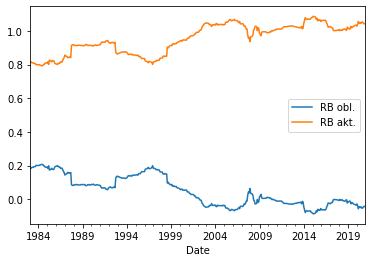

In [68]:
risikobidrag_60_40.plot()

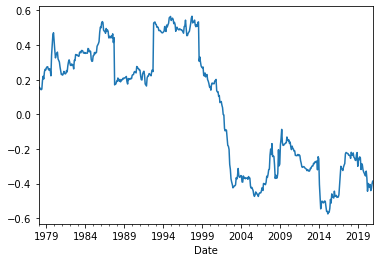

In [69]:
akt_obl_cov = mnd_afkast['Aktier'].rolling(60).corr(mnd_afkast['Obligationer']).dropna().plot()

### Herfindahl index

<AxesSubplot:xlabel='Date'>

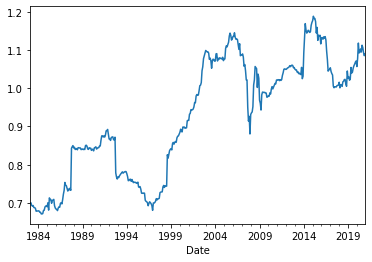

In [70]:
HI_6040 = (risikobidrag_60_40**2).sum(axis=1)
HI_6040.plot()

In [71]:
HI_6040.to_excel('HI.xlsx')

In [72]:
HI_naiv = (risikobidrag_naiv_rp**2).sum(axis=1)

# Diverse grafer og plots til delanalyse 1

## Plot af afkast

In [73]:
from scipy.stats import norm
import seaborn as sns

/Users/SusanneKrebs/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[]

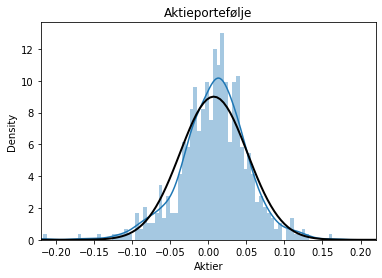

In [74]:
mu, std = norm.fit(mnd_afkast['Aktier'])
#plt.hist(mnd_afkast['Aktier'].dropna(), bins=75, density=True)
sns.distplot(mnd_afkast['Aktier'].dropna(), bins=75)
xmin, xmax = plt.xlim(-0.22,0.22)
#plt.ylim(0, 38)
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.title("Aktieportefølje")
plt.plot()

/Users/SusanneKrebs/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[]

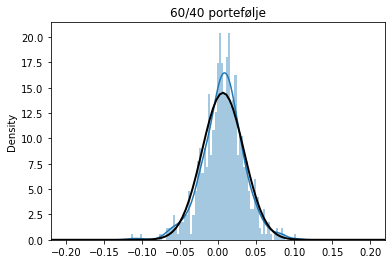

In [75]:
mu, std = norm.fit(pf_6040)
#plt.hist(pf_6040.dropna(), bins=75, density=True)
sns.distplot(pf_6040.dropna(), bins=75)
xmin, xmax = plt.xlim(-0.22,0.22)
#plt.ylim(0, 38)
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.title("60/40 portefølje")
plt.plot()

/Users/SusanneKrebs/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[]

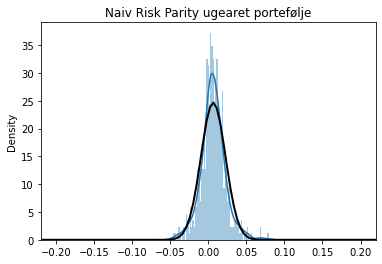

In [76]:
mu, std = norm.fit(afkast_naiv_rp_ug)
#plt.hist(afkast_naiv_rp_ug.dropna(), bins=75, density=True)
sns.distplot(afkast_naiv_rp_ug.dropna(), bins=75)
xmin, xmax = plt.xlim(-0.22,0.22)
#plt.ylim(0, 38)
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.title("Naiv Risk Parity ugearet portefølje")
plt.plot()

/Users/SusanneKrebs/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[]

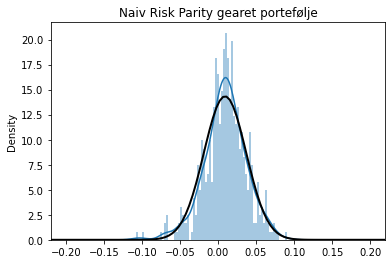

In [77]:
mu, std = norm.fit(afkast_naiv_rp_g)
#plt.hist(afkast_naiv_rp_g.dropna(), bins=75, density=True)
sns.distplot(afkast_naiv_rp_g.dropna(), bins=75)
xmin, xmax = plt.xlim(-0.22,0.22)
#plt.ylim(0, 38)
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.title("Naiv Risk Parity gearet portefølje")
plt.plot()

## Plot af Wealth Index og Drawdrown

In [78]:
def drawdown(return_series: pd.Series):
    """
    Takes a time series of asset returns
    Computes and returns a DataFrame that contains:
    the wealth index
    the previous peaks
    percent drawdowns
    """
    wealth_index = 100*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({
        "Wealth": wealth_index,
        "Peaks": previous_peaks,
        "Drawdown": -drawdowns
    })

## Aktie portefølje

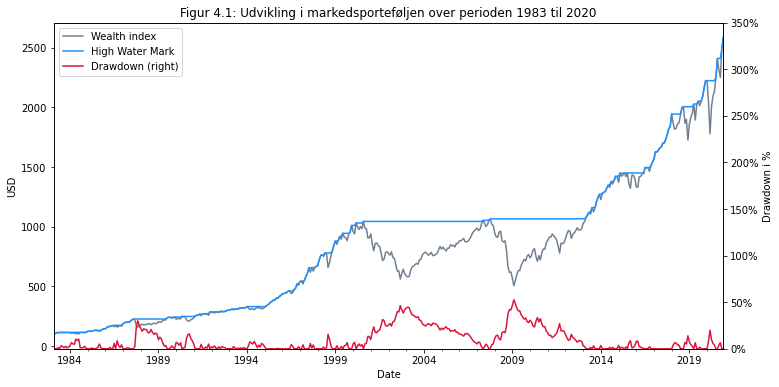

In [79]:
drawdown(pf_aktie['Aktie']['1983-02':])["Wealth"]\
.plot(label='Wealth index', figsize=(12,6), color='slategrey', legend=True,\
      title='Figur 4.1: Udvikling i markedsporteføljen over perioden 1983 til 2020')
plt.xlabel('Dato')

ax1 = drawdown(pf_aktie['Aktie']['1983-02':])["Peaks"]\
.plot(label='High Water Mark', figsize=(12,6), color='dodgerblue', legend=True)
plt.ylabel('USD')

ax2 = drawdown(pf_aktie['Aktie']['1983-02':])['Drawdown']\
.plot(label='Drawdown', secondary_y=True, color='crimson', legend=True)
ax2.set_ylim(0,3.5)
plt.ylabel('Drawdown i %')
ax2.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))

### 60/40 portefølje

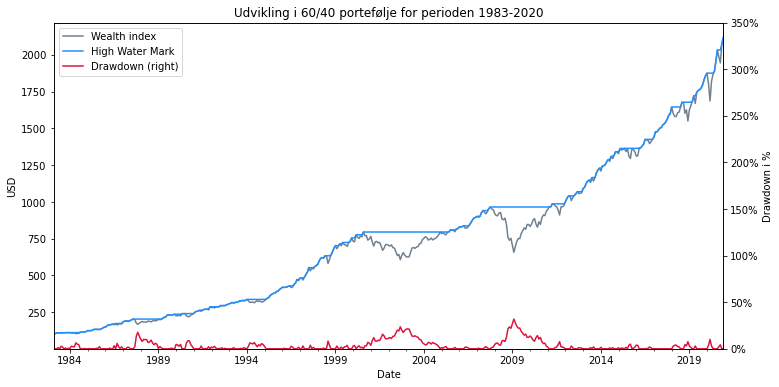

In [80]:
drawdown(pf_6040['60/40 portefølje']['1983-02':])["Wealth"]\
.plot(label='Wealth index', figsize=(12,6), color='slategrey', legend=True,\
      title='Udvikling i 60/40 portefølje for perioden 1983-2020')

ax1 = drawdown(pf_6040['60/40 portefølje']['1983-02':])["Peaks"]\
.plot(label='High Water Mark', figsize=(12,6), color='dodgerblue', legend=True)
plt.ylabel('USD')
plt.xlabel('Dato')

ax2 = drawdown(pf_6040['60/40 portefølje']['1983-02':])['Drawdown']\
.plot(label='Drawdown', secondary_y=True, color='crimson', legend=True)
ax2.set_ylim(0,3.5)
plt.ylabel('Drawdown i %')
ax2.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))

## RP ugearet

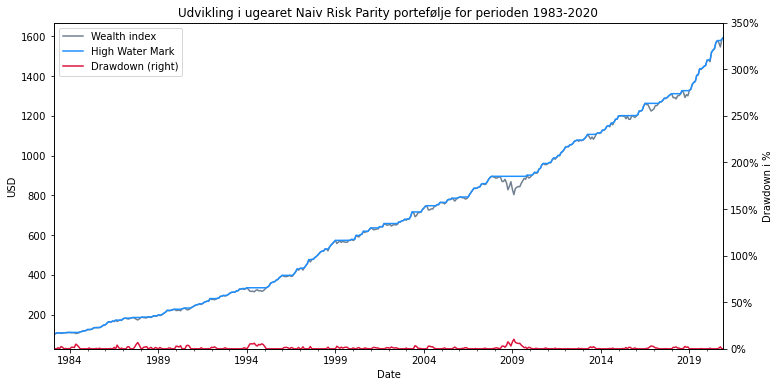

In [81]:
drawdown(afkast_naiv_rp_ug['Risk Parity Ugearet afkast']['1983-02':])["Wealth"]\
.plot(label='Wealth index', figsize=(12,6), color='slategrey', legend=True,\
      title='Udvikling i ugearet Naiv Risk Parity portefølje for perioden 1983-2020')

ax1 = drawdown(afkast_naiv_rp_ug['Risk Parity Ugearet afkast']['1983-02':])["Peaks"]\
.plot(label='High Water Mark', figsize=(12,6), color='dodgerblue', legend=True)
plt.ylabel('USD')
plt.xlabel('Dato')

ax2 = drawdown(afkast_naiv_rp_ug['Risk Parity Ugearet afkast']['1983-02':])['Drawdown']\
.plot(label='Drawdown', secondary_y=True, color='crimson', legend=True)
ax2.set_ylim(0,3.5)
plt.ylabel('Drawdown i %')
ax2.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))

## RP gearet

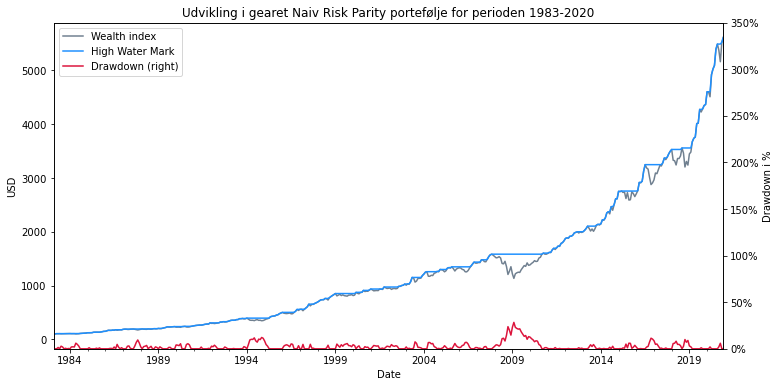

In [82]:
drawdown(afkast_naiv_rp_g['Risk Parity Gearet afkast']['1983-02':])["Wealth"]\
.plot(label='Wealth index', figsize=(12,6), color='slategrey', legend=True,\
      title='Udvikling i gearet Naiv Risk Parity portefølje for perioden 1983-2020')

ax1 = drawdown(afkast_naiv_rp_g['Risk Parity Gearet afkast']['1983-02':])["Peaks"]\
.plot(label='High Water Mark', figsize=(12,6), color='dodgerblue', legend=True)
plt.ylabel('USD')
plt.xlabel('Dato')

ax2 = drawdown(afkast_naiv_rp_g['Risk Parity Gearet afkast']['1983-02':])['Drawdown']\
.plot(label='Drawdown', secondary_y=True, color='crimson', legend=True)
ax2.set_ylim(0,3.5)
plt.ylabel('Drawdown i %')
ax2.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))

# Diverse figurer til Delanalyse 1

## Graf og statistik over prisudvikling over tid for aktier og obligationer

In [ ]:
mnd_afkast

Text(0.5, 0, 'Dato')

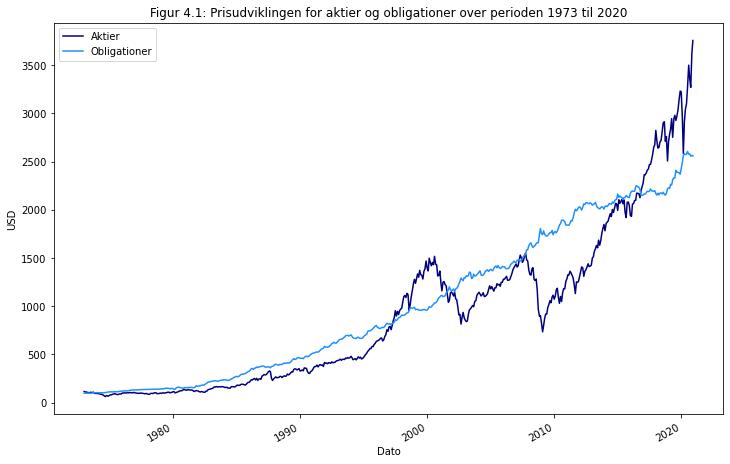

In [84]:
mnd_data['SP500'].plot(label='Aktier', figsize=(12,8), color='navy', legend=True,\
      title='Figur 4.1: Prisudviklingen for aktier og obligationer over perioden 1973 til 2020')

ax1 = mnd_data['Bonds'].plot(label='Obligationer', figsize=(12,8), color='dodgerblue', legend=True)
plt.ylabel('USD')
plt.xlabel('Dato')

### Største drawdowns i SP500

In [85]:
sp500_afkast = d1_data['SP500'].pct_change().dropna()

<AxesSubplot:title={'center':'Drawdowns på S&P 500 Indekset 1983-2020'}, xlabel='Date'>

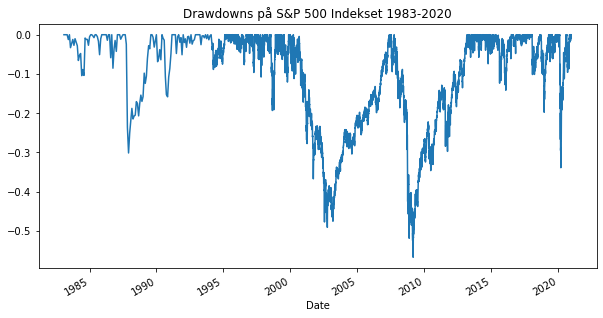

In [86]:
d1.drawdown(sp500_afkast)['Drawdown']['1983':].plot(figsize = (10,5), title='Drawdowns på S&P 500 Indekset 1983-2020')